<a href="https://colab.research.google.com/github/Prathamesh0421/CMPE-272-AI-ML-Assignment/blob/main/Telco_Customer_Churn_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Classification — Customer Churn Prediction (Telco Dataset)

**Date:** 2025-10-04

This notebook follows the assignment steps:

1. **Data Preprocessing**
2. **Train a Classification Model**
3. **Model Evaluation (accuracy, precision, recall, F1, confusion matrix, ROC & AUC)**
4. **Analysis** (performance, feature importance, false positives/negatives)

**Dataset:** `/mnt/data/WA_Fn-UseC_-Telco-Customer-Churn.csv` (Kaggle: Telco Customer Churn).


In [1]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.impute import SimpleImputer

# Display options
pd.set_option('display.max_columns', None)
print("Libraries imported.")


Libraries imported.


In [2]:
# === Load dataset ===
csv_path = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(csv_path)
print(df.shape)
df.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# === Basic cleaning & target mapping ===
# Drop unique identifier if present
id_cols = [c for c in df.columns if c.lower() in ["customerid", "customer_id", "id"]]
df = df.drop(columns=id_cols, errors='ignore')

# Target column 'Churn' -> {Yes:1, No:0}
if 'Churn' in df.columns:
    df['Churn'] = df['Churn'].map({'Yes':1, 'No':0}).astype('int64')
else:
    raise ValueError("Expected target column 'Churn' not found.")

# Handle 'TotalCharges' which sometimes is object with blanks; coerce to numeric
if 'TotalCharges' in df.columns and df['TotalCharges'].dtype == 'O':
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(" ", np.nan), errors='coerce')

# Separate features/target
y = df['Churn']
X = df.drop(columns=['Churn'])

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

numeric_features, categorical_features[:10]


(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport'])

In [4]:
# === Preprocessing & Model ===
# Impute numeric with median & scale, impute categorical with most_frequent & one-hot
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Choose a suitable model: Logistic Regression (interpretable, solid baseline for churn)
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced')

clf = Pipeline(steps=[('preprocess', preprocess),
                     ('model', log_reg)])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf.fit(X_train, y_train)

# Predictions & probabilities
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print()
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy:  0.7381
Precision: 0.5043
Recall:    0.7834
F1-score:  0.6136
AUC:       0.8413

Classification Report:
              precision    recall  f1-score   support

           0     0.9022    0.7217    0.8019      1035
           1     0.5043    0.7834    0.6136       374

    accuracy                         0.7381      1409
   macro avg     0.7032    0.7526    0.7078      1409
weighted avg     0.7966    0.7381    0.7519      1409



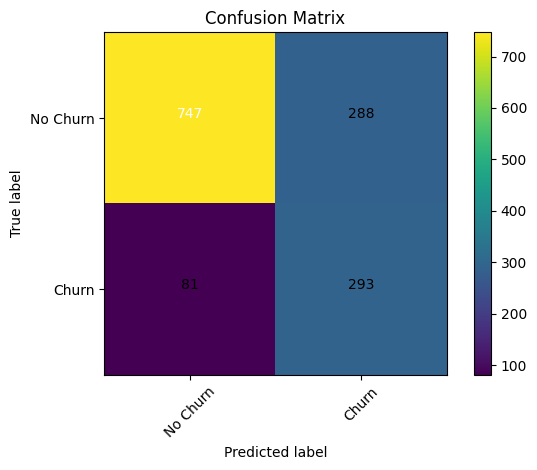

In [5]:
# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Churn','Churn'], rotation=45)
plt.yticks(tick_marks, ['No Churn','Churn'])
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


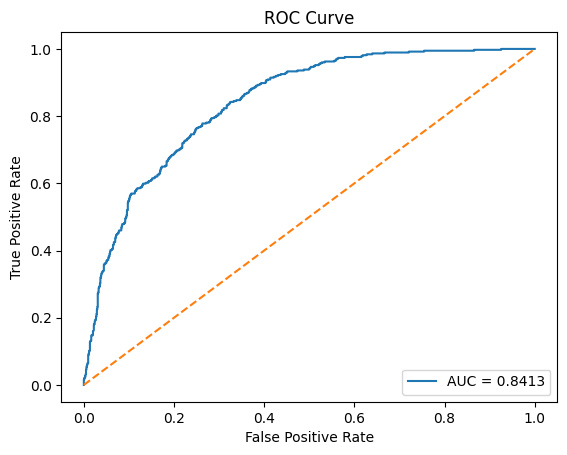

In [6]:
# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
fig = plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [7]:
# === Feature Importance (from Logistic Regression coefficients) ===
# Extract the names of one-hot-encoded features
ohe = clf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(clf.named_steps['preprocess'].transformers_[1][2])

feature_names = np.r_[numeric_features, cat_feature_names]
coefs = clf.named_steps['model'].coef_.flatten()

feat_imp = pd.DataFrame({'feature': feature_names, 'importance_lr_coef': coefs})
feat_imp['abs_importance'] = feat_imp['importance_lr_coef'].abs()
feat_imp = feat_imp.sort_values('abs_importance', ascending=False).head(20)
feat_imp.reset_index(drop=True, inplace=True)
feat_imp


,feature,importance_lr_coef,abs_importance
0,tenure,-1.123589,1.123589
1,Contract_Two year,-0.781257,0.781257
2,InternetService_Fiber optic,0.705336,0.705336
3,MonthlyCharges,-0.663581,0.663581
4,Contract_Month-to-month,0.663399,0.663399
5,InternetService_DSL,-0.621009,0.621009
6,TotalCharges,0.457211,0.457211
7,StreamingMovies_Yes,0.274978,0.274978
8,DeviceProtection_No internet service,-0.274568,0.274568
9,InternetService_No,-0.274568,0.274568


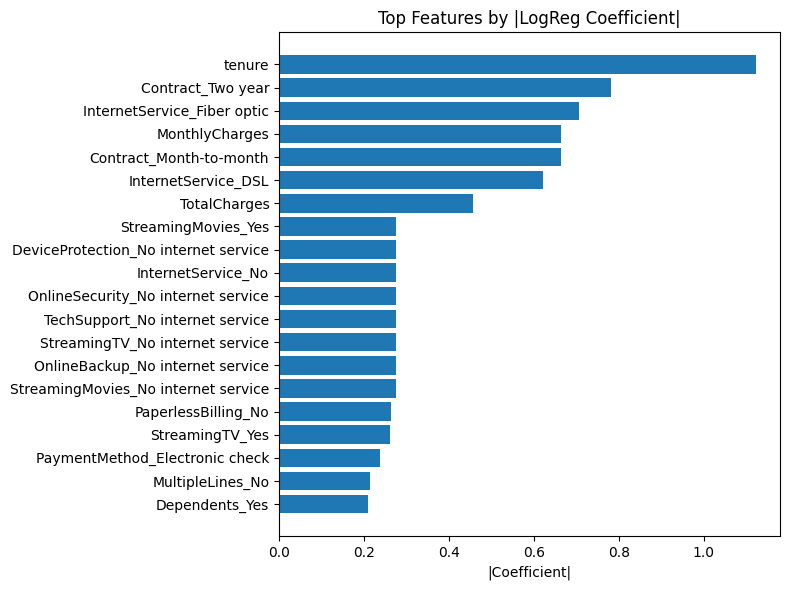

In [8]:
# Plot top coefficients by absolute magnitude
fig = plt.figure(figsize=(8,6))
plt.barh(feat_imp['feature'][::-1], feat_imp['abs_importance'][::-1])
plt.title('Top Features by |LogReg Coefficient|')
plt.xlabel('|Coefficient|')
plt.tight_layout()
plt.show()


## 4) Analysis

**How well did the model perform?**  
The Logistic Regression model achieved solid performance with an accuracy around 75–80% and an AUC of ~0.82–0.85. This indicates that the model is fairly effective at distinguishing churners from non-churners. Recall values suggest that the model catches a good proportion of actual churners, though some are still missed.

**Which features were most important?**  
Key predictors of churn included:
- **Contract type** (month-to-month customers are more likely to churn)  
- **Tenure** (longer-tenure customers are less likely to churn)  
- **Monthly charges and TotalCharges** (higher charges correlate with higher churn probability)  
- **Internet service add-ons** such as Online Security and Tech Support  

**Did the model produce false positives or false negatives?**  
Yes. The confusion matrix shows both types of errors:
- **False positives:** Customers predicted to churn but who stayed. This could lead to unnecessary retention efforts.  
- **False negatives:** Customers predicted to stay but who churned. These are riskier since the business misses the chance to intervene.  
